In [ ]:
# Install new libraries if needed

# !pip install gensim
# !pip install wordcloud
# !pip install pyldavis

In [136]:
# Import libraries

from collections import Counter # Count most common words
import gensim # word2vec model
import matplotlib.pyplot as plt
%matplotlib inline
import nltk # natural language toolkit
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews # another dataset 
import numpy as np 
import os
import pandas as pd
import pyLDAvis.sklearn # visualize our topic models!
import re # regular expressions
import seaborn as sns
# Preprocessing
import gensim
# CV (multiple train/test splitting)
from sklearn.model_selection import cross_val_score, train_test_split
# Algorithms (unsupervised)
from sklearn.decomposition import LatentDirichletAllocation, PCA
# (supervised)
from sklearn.linear_model import LogisticRegression
# Tools to create our DTMs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# Speed up your machine learning setup
from sklearn.pipeline import Pipeline
# Mix up our training and test sets
from sklearn.utils import shuffle
# Super awesome NLP library
import spacy
# Visualize word clouds 
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

# Learning objectives

1. Fit an LDA topic model and visualize it
2. Fit a word2vec model and visualize it
3. Build a classifier
4. Learn a little about BERT!

# Topic modeling

There are many topic modeling algorithms, but we'll start with [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). This is a standard **unsupervised** machine learning text-mining tool that can be used to discover abstract "topics" contained within texts.

See [this cool animation](https://en.wikipedia.org/wiki/File:Topic_model_scheme.webm) on Wikipedia to get an idea about topic modeling works.

## Vocabulary

- **Topic Modeling:** A general class of statistical models that uncover abstract topics within a text. It uses the co-occurrence of words within documents, compared to their distribution across documents, to uncover these abstract themes. The output is a list of weighted words, which indicate the subject of each topic, and a weight distribution across topics for each document.
    
- **LDA:** Latent Dirichlet Allocation. A particular model for topic modeling. It does not take document order into account, unlike other topic modeling algorithms. Also see word2vec and BERT! (Week 5)

Like the rest of this class, the goal is not to learn everything about topic modeling. Instead, this notebook will provide you with some starter code to run some simple models with the idea that you can use this base of knowledge to explore further. Use the `sklearn` help files, Stack Overflow, and Google searching to review and learn more about what the code is doing and how to go further. 

Can you make this code work for your own data? Can you tweak the parameters to get better output?

# Create a dataframe from individual text files

You've gathered a bunch of text files, so now what? It is useful to get these files into a dataframe. Python does not make this terribly easy for the beginner, so use the boilerplate code below to help you.

Let's concatenate the eleven text files in the "Data/human-rights/" folder into a dataframe so we can manipulate that text like we have seen in the previous few notebooks.

In [137]:
# Where am I?
%pwd

'/Users/tomvannuenen/Documents/GitHub/DIGHUM101-2022/Notebooks/Week5'

In [138]:
# Define a variable with the file path for the directory containing the text files
# Go two directories up (../../) 
# and into the Data directory
# then into the human-rights subdirectory
dir_path = os.listdir("../../Data/human-rights/")

# View the contents of this directory
dir_path

['sanmarino2014.txt',
 'tuvalu2013.txt',
 'kazakhstan2014.txt',
 'cotedivoire2014.txt',
 'fiji2014.txt',
 'bangladesh2013.txt',
 'turkmenistan2013.txt',
 'jordan2013.txt',
 'monaco2013.txt',
 'afghanistan2014.txt',
 'djibouti2013.txt']

In [139]:
# Designate an empty dictionary to store the filename and text as columns
for_dataframe = {}

# Loop through the directory of text files and open and read them
for file in dir_path:
    with open("../../Data/human-rights/" + file, "r", encoding="utf-8") as to_open:
         for_dataframe[file] = to_open.read()
            
# Create and append the dataframe with two columns - the file name and the text itself
human_rights = (pd.DataFrame.from_dict(for_dataframe, 
                                       orient = "index")
                .reset_index().rename(index = str, 
                                      columns = {"index": "File", 0: "Text"}))

In [140]:
human_rights

,File,Text
0,sanmarino2014.txt,\n United Nations \n A/HRC/28/9 \n \n \n\n Ge...
1,tuvalu2013.txt,\n United Nations \n A/HRC/24/8 \n \n \n\n G...
2,kazakhstan2014.txt,\n United Nations \n A/HRC/28/10 \n \n \n\n G...
3,cotedivoire2014.txt,\nDistr.: General 7 July 2014 English Original...
4,fiji2014.txt,\n United Nations \n A/HRC/28/8 \n \n \n\n Ge...
5,bangladesh2013.txt,\n United Nations \n A/HRC/24/12 \n \n \n\n ...
6,turkmenistan2013.txt,\n United Nations \n A/HRC/24/3 \n \n \n\n G...
7,jordan2013.txt,\nDistr.: General 6 January 2014 \nOriginal: E...
8,monaco2013.txt,\nDistr.: General 3 January 2014 English Origi...
9,afghanistan2014.txt,\nDistr.: General 4 April 2014 \nOriginal: Eng...


# Review - manipulate and explore text

In [141]:
# Check out text of one row to make sure it looks okay...
human_rights.iloc[0,1][:1000]

' \n United Nations \n A/HRC/28/9 \n \n \n\n General Assembly \n Distr.: General \n24 December 2014 \n \nOriginal: English \n \n\nHuman Rights Council \n\nTwenty-eighth session \nAgenda item 6 \nUniversal Periodic Review \n  Report of the Working Group on the Universal Periodic Review* \n * The annex to the present report is circulated as received. \n  San Marino \nContents \n Paragraphs Page \n  Introduction .............................................................................................................  1Ð4 3 \n I. Summary of the proceedings of the review process ................................................  5Ð77 3 \n  A. Presentation by the State under review ...........................................................  5Ð23 3 \n  B. Interactive dialogue and responses by the State under review ........................  24Ð77 6 \n II. Conclusions and/or recommendations .....................................................................  78Ð81 13 \n Annex \n  Composi

# Basic preprocessing

Preprocess the text! What else might you want to do that is not included here? Lemmatization? 

In [142]:
human_rights["Text_processed"] = human_rights["Text"].apply(gensim.utils.simple_preprocess)

human_rights["Text_processed"] 

0     [united, nations, hrc, general, assembly, dist...
1     [united, nations, hrc, general, assembly, dist...
2     [united, nations, hrc, general, assembly, dist...
3     [distr, general, july, english, original, engl...
4     [united, nations, hrc, general, assembly, dist...
5     [united, nations, hrc, general, assembly, dist...
6     [united, nations, hrc, general, assembly, dist...
7     [distr, general, january, original, english, g...
8     [distr, general, january, english, original, e...
9     [distr, general, april, original, english, gen...
10    [distr, general, july, english, original, engl...
Name: Text_processed, dtype: object

In [143]:
# Using gensim for preprocessing using .apply()
processed = human_rights["Text"].apply(gensim.utils.simple_preprocess)

# Stopword removal using NLTK stopword list and a lambda function
stop = stopwords.words('english')
no_stop = processed.apply(lambda x: [w for w in x if w not in stopwords.words('english')]) 

# Convert list back to str
human_rights["Text_processed"] = [' '.join(t) for t in no_stop]

In [144]:
human_rights

,File,Text,Text_processed
0,sanmarino2014.txt,\n United Nations \n A/HRC/28/9 \n \n \n\n Ge...,united nations hrc general assembly distr gene...
1,tuvalu2013.txt,\n United Nations \n A/HRC/24/8 \n \n \n\n G...,united nations hrc general assembly distr gene...
2,kazakhstan2014.txt,\n United Nations \n A/HRC/28/10 \n \n \n\n G...,united nations hrc general assembly distr gene...
3,cotedivoire2014.txt,\nDistr.: General 7 July 2014 English Original...,distr general july english original english fr...
4,fiji2014.txt,\n United Nations \n A/HRC/28/8 \n \n \n\n Ge...,united nations hrc general assembly distr gene...
5,bangladesh2013.txt,\n United Nations \n A/HRC/24/12 \n \n \n\n ...,united nations hrc general assembly distr gene...
6,turkmenistan2013.txt,\n United Nations \n A/HRC/24/3 \n \n \n\n G...,united nations hrc general assembly distr gene...
7,jordan2013.txt,\nDistr.: General 6 January 2014 \nOriginal: E...,distr general january original english general...
8,monaco2013.txt,\nDistr.: General 3 January 2014 English Origi...,distr general january english original english...
9,afghanistan2014.txt,\nDistr.: General 4 April 2014 \nOriginal: Eng...,distr general april original english general a...


In [145]:
human_rights['Text_processed'][0][:1000]

'united nations hrc general assembly distr general december original english human rights council twenty eighth session agenda item universal periodic review report working group universal periodic review annex present report circulated received san marino contents paragraphs page introduction summary proceedings review process presentation state review interactive dialogue responses state review ii conclusions recommendations annex composition delegation introduction working group universal periodic review established accordance human rights council resolution june held twentieth session october november review san marino held th meeting october delegation san marino headed pasquale valentini minister foreign affairs th meeting held october working group adopted report san marino january human rights council selected following group rapporteurs troika facilitate review san marino burkina faso chile china accordance paragraph annex resolution paragraph annex resolution following docume

In [146]:
# Tokenize long_string
hr_str = ' '.join(human_rights['Text_processed'].tolist())
hr_tok = hr_str.split()
freq_hr = Counter(hr_tok)

# Print the 10 most common words
hr_df = pd.DataFrame(freq_hr.most_common(10), columns = ["Word", "Frequency"])
hr_df

,Word,Frequency
0,rights,1717
1,human,1204
2,women,725
3,international,691
4,national,683
5,made,639
6,recommendations,598
7,efforts,527
8,continue,453
9,violence,431


# Define a BOW model

In [147]:
# Define an empty bag (of words)
vectorizer = CountVectorizer()

# Use the .fit method to tokenize the text and learn the vocabulary
vectorizer.fit(human_rights["Text_processed"])

CountVectorizer()

# Create the DTM

Recall that a [document term matrix](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) displays term frequencies or TFIDF scores that occur across a collection of documents. We want to encode the documents into a [sparse matrix](https://sebastianraschka.com/faq/docs/bag-of-words-sparsity.html#:~:text=By%20definition%2C%20a%20sparse%20matrix,as%20a%20word%2Dcount%20vector.&text=Thus%2C%20if%20most%20of%20your,most%20likely%20sparse%20as%20well!) to represent the frequencies or TFIDF scores of each vocabulary word across the documents.

Again, the column headers could read **(document number, term)   frequency**

In [148]:
# Encode the documents
vector = vectorizer.transform(human_rights["Text_processed"])

print(type(vector))
print(vector.shape)
print(vector) 

<class 'scipy.sparse.csr.csr_matrix'>
(11, 5070)
  (0, 6)	1
  (0, 7)	1
  (0, 12)	4
  (0, 21)	1
  (0, 23)	1
  (0, 26)	1
  (0, 28)	1
  (0, 29)	15
  (0, 32)	5
  (0, 33)	2
  (0, 34)	4
  (0, 35)	1
  (0, 41)	6
  (0, 43)	4
  (0, 45)	2
  (0, 47)	8
  (0, 55)	9
  (0, 57)	3
  (0, 60)	2
  (0, 69)	1
  (0, 75)	2
  (0, 82)	2
  (0, 84)	1
  (0, 85)	1
  (0, 86)	2
  :	:
  (10, 4970)	1
  (10, 4973)	2
  (10, 4974)	1
  (10, 4978)	1
  (10, 4979)	1
  (10, 4988)	5
  (10, 4989)	1
  (10, 4994)	72
  (10, 4995)	15
  (10, 4997)	7
  (10, 4999)	3
  (10, 5003)	7
  (10, 5011)	1
  (10, 5012)	5
  (10, 5013)	2
  (10, 5014)	1
  (10, 5019)	1
  (10, 5020)	2
  (10, 5022)	2
  (10, 5023)	2
  (10, 5025)	1
  (10, 5031)	1
  (10, 5040)	1
  (10, 5045)	1
  (10, 5056)	1


In [149]:
# View as a multidimensional array before converting to data frame
# Rows are the documents, columns are the terms

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


In [150]:
# Preview the terms

vectorizer.get_feature_names()[0:10]

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abasi',
 'abdi',
 'abdou',
 'abduction',
 'abdul',
 'abdullah',
 'abide',
 'abiding',
 'abilities',
 'ability']

# Define a bigram bag of words

In [151]:
# What other processing steps could you include here
# ... instead of doing them manually above? 

bigram_vectorizer = CountVectorizer(ngram_range = (1,2),
                                    stop_words = "english",
                                    token_pattern = r'\b\w+\b', 
                                    min_df = 1)

bigram_vectorizer

CountVectorizer(ngram_range=(1, 2), stop_words='english',
                token_pattern='\\b\\w+\\b')

In [152]:
# Analyze long_string in the bigram bag of words

analyze = bigram_vectorizer.build_analyzer()
vocab = analyze(long_string)

vocab[0:10]

['united',
 'nations',
 'hrc',
 'general',
 'assembly',
 'distr',
 'general',
 'december',
 'original',
 'english']

In [153]:
# Show the 20 most commons
freq = Counter(vocab)
stop_df = pd.DataFrame(freq.most_common(20), columns = ["Word", "Frequency"])
stop_df

,Word,Frequency
0,rights,1717
1,human,1204
2,human rights,1112
3,women,725
4,international,691
5,national,683
6,recommendations,598
7,efforts,527
8,continue,453
9,violence,431


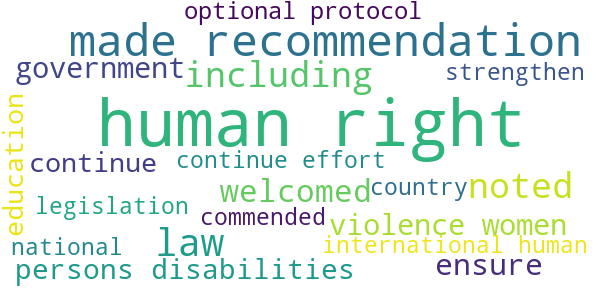

In [154]:
# Define a word cloud variable
cloud = WordCloud(background_color = "white", 
                  max_words = 20, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5)

# Process the word cloud
cloud.generate(long_string)

# Visualize!
cloud.to_image()

Learn about using [custom colors here](https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html)

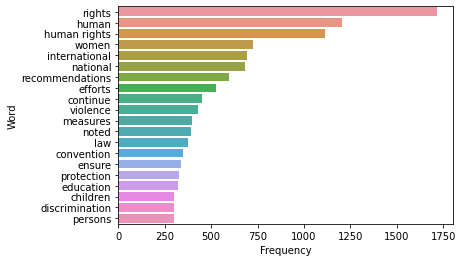

In [155]:
# Visualize word frequencies in a horizontal bar plot

sns.barplot(x = "Frequency",
            y = "Word",
            data = stop_df,
            orient = "h");

# Finally! Fit the topic model

The input to LDA should be a DTM!

In [156]:
# Predetermine the number of topics

n_topics = 5
# n_topics = 20

In [157]:
# TfidfVectorizer to create the DTM
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90,
                                   max_features = 500,
                                   stop_words = "english")

# Fit
tfidf = tfidf_vectorizer.fit_transform(hr_tokens)

[Check out this question](https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer) to learn more about the `max_df` and `min_df` arguments. 

In [158]:
# Instantiate our LDA model (this might take a minute or two)
lda = LatentDirichletAllocation(n_components = n_topics, 
                                max_iter = 20, 
                                random_state = 42)
lda = lda.fit(tfidf)

In [159]:
# Here is a function to print out the top words for each topic in a pretty way:

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx+1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [160]:
# Return the topics
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #1:
monaco, kazakhstan, dõivoire, te, kazakhstanõs, reconciliation, monegasque, ivorian, principality, truth, des, nationality, op, crisis, crpd, post, impunity, said, death, registration

Topic #2:
turkmenistan, djibouti, bangladesh, bangladeshõs, djiboutiõs, fgm, op, cat, death, recommendation, said, minorities, care, strategic, media, mortality, conditions, journalists, population, cedaw

Topic #3:
europe, ghana, op, crc, european, recommendation, said, sierra, leone, police, enforced, ilo, specific, institution, racial, crpd, portugal, core, compliance, restrictions

Topic #4:
fiji, media, fijian, decree, industry, elections, judiciary, iccpr, police, portugal, treaties, cat, speech, core, independence, zealand, association, lawyers, climate, ghana

Topic #5:
tuvalu, jordan, san, afghanistan, marino, afghan, peace, jordanian, media, publications, stateõs, water, syrian, refugees, police, treaties, cent, community, increased, moratorium


/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [161]:
panel = pyLDAvis.sklearn.prepare(lda_model = lda, 
                                 dtm = tfidf, 
                                 vectorizer = tfidf_vectorizer, 
                                 mds = "tsne")
pyLDAvis.display(panel)

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 's

# Challenge 1

1. What is a topic? 
2. What is a "salient" term?
3. What is the relevance metric lambda?

4. What do you know about the eleven human rights documents we used to do this exercise? 
5. Why are all these topics similar in size in the left plot?
6. Why are the overall term frequencies (blue bar) and estimated term frequency, within the selected topic (red bar) similar in the right plot? 
7. Plug in your own data! You might see more distinct topics given the nature of these human rights documents. Why? 

# Challenge 2

Read up on LDA and its visualizations by clicking the below links:
- https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/
- http://www.cs.columbia.edu/~blei/papers/ChaneyBlei2012.pdf
- https://shravan-kuchkula.github.io/topic-modeling/#lda-results
- https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
- http://vis.stanford.edu/files/2012-Termite-AVI.pdf

# word2vec

The word2vec family of algorithms use shallow neural networks to produce word embeddings, or ways to represent similar words similarly as numbers. We will explore neural network architecture in notebook 5-2. 

In [ ]:
# First, store the documents we want to explore in a separate dataframe with just one column
w2v_df = pd.DataFrame({'Processed': human_rights["Text_processed"]})
w2v_df

In [ ]:
# Turn the text of each row into a list
# We now have a list of lists - one for each document

split_rows = [row.split() for row in w2v_df['Processed']]

In [ ]:
# Define the word2vec model

model = gensim.models.Word2Vec(split_rows, 
                               min_count = 2,
                               size = 12, 
                               workers = 3, 
                               window = 3, 
                               sg = 1)

In [ ]:
# Save the vocabulary 
words = list(model.wv.vocab)

# Preview
words[0:10]

In [ ]:
# Inspect the vector for a word in the vocabulary

model["human"]

In [ ]:
# compare the vectors of two words in the vocabulary
model.similarity("the", "the")

In [ ]:
model.similarity("human", "rights")

In [ ]:
model.similarity("human", "the")

In [ ]:
model.similarity("human", "law")

In [ ]:
model.similarity("country", "law")

In [ ]:
model.similarity("justice", "law")

In [ ]:
model.similarity("international", "law")

In [ ]:
model.similarity("united", "nations")

In [ ]:
# Get the most similar words to a given word
human_words = model.wv.most_similar("human", topn=10)
print(type(human_words))
human_words

In [ ]:
# Convert into a dataframe
pd.DataFrame(human_words,columns=['Word', "Similarity"])

In [ ]:
model.wv.most_similar("war")

In [ ]:
model.similarity("peace", "human")

In [ ]:
model.similarity("war", "humanity")

# Plot words with PCA

[Principal component analysis](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) and related dimension-reduction algorithms are an excellent way to visualize multivariate data in reduced dimensional space - such as a 2D scatterplot. 

In [ ]:
# Save the word2vec vocab vectors
features = model[model.wv.vocab]
features

In [ ]:
# Define parameters of our PCA

# Just look at the first two dimensions - the X and Y axes
for_pca = PCA(n_components = 2)
pca_out = for_pca.fit_transform(features)

In [ ]:
# Plot!
plt.scatter(pca_out[:, 0], pca_out[:, 1]);

# Annotate text labels

What if we want to lable points with just certain words? 

In [ ]:
plt.figure(figsize = (8,6))
plt.scatter(pca_out[:, 0], pca_out[:, 1])
words = list(model.wv.vocab)
# Annotate only the top 20 words [0:20]
for i, word in enumerate(words[0:20]):
    plt.annotate(word, size = 20, xy = (pca_out[i, 0], pca_out[i, 1]))
plt.show()

In [ ]:
# Or, just the top 20 words?
plt.figure(figsize = (8,6))
plt.scatter(pca_out[:, 0][0:20], pca_out[:, 1][0:20])
words = list(model.wv.vocab)
for i, word in enumerate(words[0:20]):
    plt.annotate(word, size = 20, xy=(pca_out[i, 0], pca_out[i, 1]))
plt.show()

https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XuxYm2pKjOQ

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

https://www.datacamp.com/community/blog/spacy-cheatsheet

https://code.google.com/archive/p/word2vec/

# Classification of Textual Data

How can we translate this simple model of binary classification to text? Let's look at a corpus from `nltk` and build your own classifier using sklearn's machine learning `Pipeline`

In [ ]:
# Download the nltk built-in movie reviews dataset
nltk.download("movie_reviews")

As you might expect, this is a corpus of IMDB movie reviews. Someone went through and read each review, labeling it as either "positive" or "negative". The task we have before us is to create a model that can accurately predict whether a never-before-seen review is positive or negative. 

From the `movie_reviews` object let's take out the reviews and the judgement:

In [ ]:
# Extract our x (reviews) and y (judgements) variables
reviews = [movie_reviews.raw(fileid) for fileid in movie_reviews.fileids()]
judgements = [movie_reviews.categories(fileid)[0] for fileid in movie_reviews.fileids()]

In [ ]:
# Save in a dataframe
movies = pd.DataFrame({"Reviews" : reviews, 
                      "Judgements" : judgements})

In [ ]:
movies.head()

In [ ]:
# We have 2000 movie reviews
movies.shape

Let's look at a random review and its judgement:

In [ ]:
print("The human annotator's review was:", movies.Judgements[0])
print()
print(movies.Reviews[0][:500])

So right now we have a dataframe of movie reviews in the `Reviews` variable and a list of their corresponding judgements in the `Judgements` column. Awesome. What does this sound like to you? Independent and dependent variables? You'd be right!

`Reviews` is our x variable. `Judgements` is our y variable. Let's first reassign x and y for simplicity. While we're at it, we're going to set the random_state for our computer. Remember that this makes our result reproducible. We'll also `shuffle` so that we randomize the order of our observations, and when we split the testing and training data it won't be in a biased order. However, start learning about [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) and when you should use it instead of `shuffle`!

In [ ]:
x, y = shuffle(np.array(movies.Reviews), np.array(movies.Judgements), random_state = 1)

If you don't believe me that all we did is reassign and shuffle:

In [ ]:
x[0], print("Human annotator's review was:", y[0])

To get meaningful independent variables (words) we have to do some processing too (think DTM!). With `sklearn`'s text pipelines, we can quickly build a text classifier in only a few lines of Python: 

# Cross-validated pipepline

Remember training/test splitting? Lets do this `cv = 20` times! https://en.wikipedia.org/wiki/Cross-validation_(statistics)

We should reasonably expect this to perform better than a single training/test split (see below).

In [ ]:
# Cross-validated model!
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(random_state = 0, penalty = "l2", C = 1000))
                     ])

scores = cross_val_score(text_clf, x, y, cv = 20)

print(scores, np.mean(scores))

***Whoa! What just happened?!?*** The pipeline tells us three things happened:

1. `CountVectorizer`

2. `TfidfTransformer`

3. `LogisticRegression`

Let's walk through this step by step.

1. `CountVectorizer` does the same as before. It changes all the texts to quickly normalized words, and then simply counts the frequency of each word occuring in the corpus for each document. The feature array for each document at this point is simply the length of all unique words in a corpus, with the count for the frequency of each. This is the most basic way to provide features for a classifier - a document term matrix!

2. Remember that tfidf (term frequency inverse document frequency) is an algorithm that aims to find words that are important to specific documents. It does this by taking the term frequency (tf) for a specific term in a specific document, and multiplying it by the term's inverse document frequency (idf), which is the total number of documents divided by the number of documents that contain the term at least once. `TfidfTransformer` transforms the `CountVectorizer` into a tf-idf representation. 

A tfidf value is calculated for each term for each document. The feature arrays for a document is now the tfidf values. 

> Remember! The tfidf matrix is similar to our document term matrix, only now the values have been weighted according to their distribution across documents.

The pipeline now sends these tfidf feature arrays to 

3. `LogisticRegression`, what we learned from notebook 4-3. We add in an l2 penalization parameter because we have many more independent variables from our `dtm` than observations. 

Check out the [pipeline documentation here](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

The code below breaks this down by each step, but combines the `CountVectorizer` and `TfidfTransformer` in the `TfidfVectorizer`.

In [ ]:
# Standard training/test split (no cross validation)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

# get tfidf values
tfidf = TfidfVectorizer()
tfidf.fit(x)
x_train = tfidf.transform(x_train)
x_test = tfidf.transform(x_test)

# build and test logit
logit_class = LogisticRegression(random_state = 0, penalty = "l2", C = 1000)
model = logit_class.fit(x_train, y_train)
model.score(x_test, y_test)

# Important Features

After we train the model we can then index the tfidf matrix for the words with the most significant coefficients (remember independent variables!) to get the most helpful features:

In [ ]:
feature_names = tfidf.get_feature_names()
top25pos = np.argsort(model.coef_[0])[-25:]
print("Top features for positive reviews:")
print(list(feature_names[j] for j in top25pos))
print()
print("Top features for negative reviews:")
top25neg = np.argsort(model.coef_[0])[:25]
print(list(feature_names[j] for j in top25neg))

# Prediction

We can also use our model to classify new reviews, all we have to do is extract the tfidf features from the raw text and send them to the model as our features (independent variables):

In [ ]:
new_bad_review = "This was the most awful worst super bad movie ever!"

features = tfidf.transform([new_bad_review])

model.predict(features)

In [ ]:
new_good_review = "This movie was great, awesome and good!"

features = tfidf.transform([new_good_review])

model.predict(features)

# Bidirectional Encoder Representations from Transformers (BERT)

Want to go really crazy? The [BERT algorithmic family](https://www.blog.google/products/search/search-language-understanding-bert/) is the way to go!

https://github.com/google-research/bert  
https://github.com/google-research/bert#pre-trained-models  
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/